In [55]:
import math
import numpy as np
import matplotlib.pyplot as plt
import geojson
from shapely.ops import split
from shapely.geometry import Point, LineString, Polygon, MultiPoint
from shapely.ops import nearest_points

from numpy import ones,vstack
from numpy.linalg import lstsq
import pandas as pd
import csv
import openpyxl
from itertools import islice
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay

In [2]:
pixel_size = 0.346
annotations_geo = geojson.load(open('/tmp/layers_annotations.json','rb'))
#s1_coordinates = np.array(s1_geo[0]["geometry"]["coordinates"][0]) * pixel_size

In [3]:
annotations = dict()
for entry in annotations_geo:
    annotations[entry["properties"]["name"]] = np.array(entry["geometry"]["coordinates"]) * pixel_size

In [4]:
s1_coordinates = annotations['S1'][0]
# These 4 points can not be find via an algo, so we need QuPath annotation
top_left = annotations['TOP_LEFT']
bottom_left = annotations['BOTTOM_LEFT']
top_right = annotations['TOP_RIGHT']
bottom_right = annotations['BOTTOM_RIGHT']
quadrilateral = np.array([top_left, top_right, bottom_right, bottom_left, top_left])

In [6]:
def distance(p1, p2):
    return math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

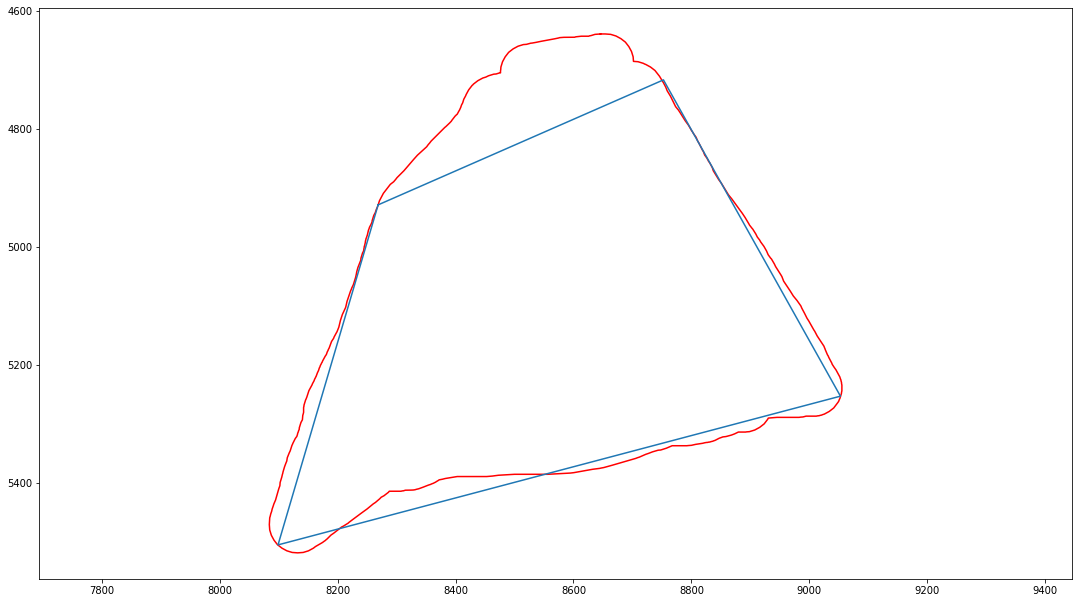

In [7]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.axis('equal')
plt.gca().invert_yaxis()
plt.plot(s1_coordinates[:,0], s1_coordinates[:,1], 'r')
plt.plot(quadrilateral[:,0], quadrilateral[:,1])

In [34]:
def getExtrapoledLine(line_string, EXTRAPOL_RATIO=1.5):
    'Creates a line extrapoled in both directions'
    p1=np.array(line_string)[0] 
    p2=np.array(line_string)[1]
    a = (p2[0]+EXTRAPOL_RATIO*(p1[0]-p2[0]), p2[1]+EXTRAPOL_RATIO*(p1[1]-p2[1]) )
    b = (p1[0]+EXTRAPOL_RATIO*(p2[0]-p1[0]), p1[1]+EXTRAPOL_RATIO*(p2[1]-p1[1]) )
    return LineString([a,b])

In [80]:
def create_grid(quadrilateral, s1_coordinates, nb_row, nb_col):
    """
    Args:
        qudrilateral(np.array): shape(5, 2). top_left, top_right, bottom_right, bottom_left, top_left
    """
    top_left = quadrilateral[0]
    top_right = quadrilateral[1]
    bottom_right = quadrilateral[2]
    bottom_left = quadrilateral[3]
    
    lines = []
    for i in range(nb_col+1):
        top_point = top_left + (top_right - top_left) / nb_col * i
        bottom_point = bottom_left + (bottom_right - bottom_left) / nb_col * i
        line = LineString([(top_point[0], top_point[1]), (bottom_point[0], bottom_point[1])])
        line = getExtrapoledLine(line, 1.3)
        try:
            intersection_line = Polygon(s1_coordinates).intersection(line).coords
            lines.append(intersection_line)
        except NotImplementedError:
        #    intersection_line = list(Polygon(quadrilateral).intersection(line).coords)
            pass
              
        
        
        
    
    horizontal_lines = []  
    for i in range(nb_row-1):
        horizontal_points = []
        for line in lines : 
            line_coord = np.array(line)
            point = line_coord[0] + (line_coord[1] - line_coord[0]) / nb_row * (i+1)
            horizontal_points.append(point)
        horizontal_lines.append(LineString(horizontal_points))

    
    return lines, horizontal_lines
    
    

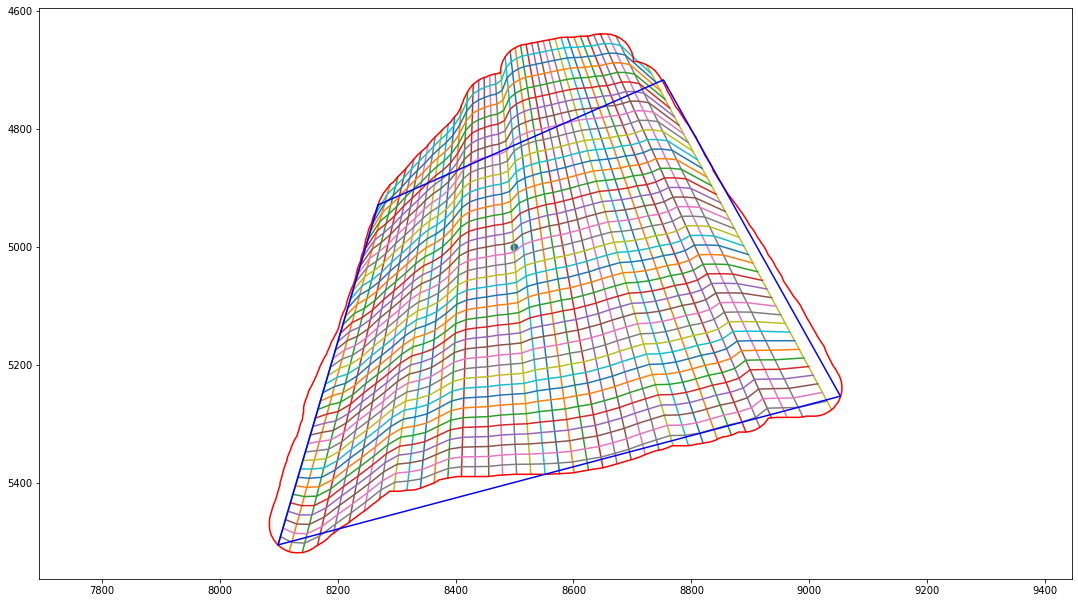

In [85]:
fig = plt.figure()
fig.set_size_inches(18.5, 10.5)
plt.axis('equal')
plt.gca().invert_yaxis()
vertical_lines, horizontal_lines = create_grid(quadrilateral, s1_coordinates, 40, 0)
for line in vertical_lines:
    line_coord = np.array(line)
    plt.plot(line_coord[:,0], line_coord[:,1])
             

for line in horizontal_lines:
    line_coord = np.array(line)
    plt.plot(line_coord[:,0], line_coord[:,1])

plt.plot(s1_coordinates[:,0], s1_coordinates[:,1], 'r')
plt.plot(quadrilateral[:,0], quadrilateral[:,1], 'b')

cell_coor = np.array([8500, 5000])
plt.scatter(cell_coor[0], cell_coor[1], s=50)


In [77]:
for line in vertical_lines:
    print(nearest_points(line, cell_coor)[0])




AttributeError: 'numpy.ndarray' object has no attribute '_geom'